In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
"""
ETL - PLTV Bubble Arena
""" 

# Configure load path
import pickle
import pandas as pd
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools

os.chdir("C:/Users/Win11/Documents/")
os.chdir("C:/Users/Win11/Documents/Repos/Poker-Hit-PLTV/")

bs_token = 'S7Fek4qridIxY1sUfYUyOl0rLak1Eedeg0TTCWHzUHqIFuUGN07xZtd41ZCp2UvE'  # Token Bingo Arena
host = 'td.winnerstudio.vip'

# Path Thinking Engine tables
tables_path = 'tables_etl_script_poker_hit.py'
start_date = (datetime.now() - timedelta(days = 80)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days = 29)).strftime('%Y-%m-%d')
client_name = 'ios'

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')


In [3]:
with open('poker_party_ptlv_dictionary_2024.pkl', 'rb') as file:
    model_dict = pickle.load(file)
model_dict.head()

,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."


## 1. Load the data and incorporate the predictions 

This should be everything that you can get from the previous step, except the API data 

In [4]:
def load_data(tables, bs_token, host):
    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 2000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print(data)
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning

    df = pull_data(tables[0], bs_token, host)
    for i in range(1, len(tables)):
        new_data = pull_data(tables[i], bs_token, host)
        df = df.merge(new_data, on = '#account_id', how = 'left')

    return df

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')
training_columns = locals().get('training_columns')
training_columns_feb = locals().get('training_columns_feb')

# Create df by loading information and joining on account_id
df = load_data(tables, bs_token, host)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
      #account_id  cp1  cp3  cp7   p1  p10  p100  p105  p11  p112  ...  p70  \
0         2306249    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
1         2306461    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
2         2307014    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
3         2307684    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
4         2309869    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
...           ...  ...  ...  ...  ...  ...   ...   ...  ...   ...  ...  ...   
69179     2451406    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
69180     2452380    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
69181     2453041    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
69182     2453397    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ...  0.0   
69183     2453790    0    0    0  0.0  0.0   0.0   0.0  0.0   0.0  ..

In [5]:
# Data preprocessing and transformations
df['#account_id'] = df['#account_id'].astype(str)
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
df = df.fillna(0)

In [6]:
# Calculate differences
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [7]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]
def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:
        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
                
                data[f'p_last_diff_7_{reg}'] = data[f'p{reg}'] - data[f'p7']
                data[f'w_last_diff_7_{reg}'] = data[f'w{reg}'] - data[f'w7']
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop=True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
                
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop=True).values[0]

                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}'] = prediction + data[f'p{reg}']- data[f'w{reg}']
                del data[f'p_last_diff_7_{reg}']
                del data[f'w_last_diff_7_{reg}']

    return data

df = add_predictions(df, model_dict, response_days_input, predictors_days_input)

## 2. Add media source 

Add the media source

In [8]:
api_details = {'bundle_id': 'com.games.holdem.pokerhit.us.ios', 'start': start_date, 'end':  end_date}
api_url = 'http://uspokerhit-gp.vegashouse.club/server/media_source_cost'
api_url = 'http://uspokerhit-ios.vegashouse.club/server/media_source_cost'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    api_df = response.json()  # Parse the JSON response if the API returns JSON data
    api_df = pd.DataFrame(api_df['data'])
    api_df['api_installs'] = api_df['user_ids'].apply(lambda x: len([int(item.strip()) for item in x.split(",") if item.strip()]))
    print('Loaded', api_df.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")



Loaded (378, 7)


In [9]:
api_df.head(20)

,date,media_source,cost,revenue_d7,withdraw_d7,user_ids,api_installs
0,20231218,moloco_int,2443.12,254.59,0.00,"2568896,2568994,2569000,2569016,2569033,256904...",126
1,20231218,FB_web,20322.09,2814.63,518.00,"2568899,2568932,2568952,2568970,2568977,256898...",475
2,20231218,ironsource_int,424.80,16.05,0.00,"2568907,2569108,2569144,2569193,2569200,256931...",72
3,20231218,unityads_int,6352.79,561.90,98.00,"2568912,2568951,2568961,2568969,2568973,256902...",399
4,20231218,applovin_int,3473.53,251.48,33.01,"2568936,2569162,2569275,2569218,2569245,256935...",150
5,20231218,vungle_int,277.40,8.30,0.00,"2569021,2113535,2569552,2569732,2517316,256985...",24
6,20231218,appier_int,48.00,27.30,0.00,"2569272,2570571,2571271,2571587,2572913,2573492",6
7,20231218,clearpierperfor,32.00,8.95,0.00,"2571650,2571755,2574307,2575312",4
8,20231217,FB_web,19775.90,2475.27,657.60,"2562151,2562154,2562170,2562173,2562217,256223...",434
9,20231217,unityads_int,5259.72,274.56,41.48,"2562146,2562158,2562186,2562193,2562198,256222...",340


In [10]:
new_column = []
for index, row in df.iterrows():
    account_id = row['#account_id']
    source = api_df[api_df['user_ids'].apply(lambda ids: account_id in ids)]['media_source'].values.tolist()
    # source = api_df[api_df['user_ids'].apply(lambda ids: account_id in ids)]['media_source'].values
    new_column.append(source) # Append the source to the new_column list

df['media_source'] = new_column

In [11]:

# Assuming df is your DataFrame
df['register_time'] = pd.to_datetime(df['register_time'], errors='coerce')

def ms_to_str(x):
    if len(x) > 0:
        x = x[0]
    else:
        x = np.nan
    return x
df.head(3763)['media_source'].apply(ms_to_str)
df['media_source'] = df['media_source'].apply(ms_to_str)
df['date'] = df['register_time'].dt.strftime('%Y%m%d').astype(float)  # Change to float if needed


In [12]:
df['media_source']
df['media_source'] = df['media_source'].astype(str)
df['media_source'].dtype

dtype('O')

In [13]:

today = pd.to_datetime((datetime.now() - timedelta(days = 1)).strftime('%Y-%m-%d'))
n_values = df.columns[df.columns.str.match(r'pred_\d+_\d+')].str.extract(r'pred_\d+_(\d+)').dropna()[0].unique() # These are the responses, after removing the availables.
available_k_values = [int(col.split('_')[1]) for col in df.columns if col.startswith('pred_')] # What are the numbers after 'pred_'
pred_list = ['pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77', 'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112', 'pred_119', 'pred_126', 'pred_133']

df['te_installs'] = 1
agg_df = df.fillna(0).groupby(['media_source', 'date'])[[col for col in df.columns if col.startswith("p") or col.startswith("w") or col.startswith("actual_")] + ['te_installs']].sum().reset_index()
agg_df = api_df[['media_source', 'date', 'api_installs', 'cost', 'revenue_d7', 'withdraw_d7']].merge(agg_df, on = ['date', 'media_source'], how = 'inner')

agg_df['payment_increase'] = (agg_df['revenue_d7'] - agg_df['p7']) / agg_df['p7']
agg_df['rpi_increase'] = ((agg_df['revenue_d7'] / agg_df['api_installs'].astype(float)) - (agg_df['p7'] / agg_df['te_installs']) / (agg_df['p7'] / agg_df['te_installs']))
agg_df['installs_difference'] = (agg_df['api_installs'] - agg_df['te_installs']) / agg_df['te_installs'] # ['Install', 'installs']'Install' is API
agg_df['is_facebook'] = (agg_df['media_source'] == 'FB_web').astype(int)
agg_df['is_moloco'] = (agg_df['media_source'] == 'moloco_int').astype(int)
agg_df['is_unity'] = (agg_df['media_source'] == 'unityads_int').astype(int)
agg_df['withdrawn_ratio'] = agg_df['withdraw_d7'] / agg_df['revenue_d7']


In [14]:
agg_df['media_source'].unique()

array(['moloco_int', 'FB_web', 'ironsource_int', 'unityads_int',
       'applovin_int', 'vungle_int', 'appier_int', 'clearpierperfor',
       'Google_web'], dtype=object)

In [15]:
# Generate pred roas cols by dividing pred_revenue by spending (Name does not change)
agg_df[[col for col in df.columns if col.startswith("pred_")]] = agg_df[[col for col in df.columns if col.startswith("pred_")]].div(agg_df['cost'], axis = 0)

In [18]:
agg_df_train = agg_df[['media_source'] + ['date'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] + ['rpi_increase'] + ['installs_difference'] 
                        + ['is_facebook'] + ['is_moloco'] + ['is_unity'] + ['withdrawn_ratio'] 
                        + [col for col in agg_df.columns if col.startswith("pred_")] + [col for col in agg_df.columns if col.startswith("w")]]

agg_df_train.sample(10)

,media_source,date,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,is_facebook,is_moloco,...,w63,w7,w70,w77,w8,w84,w9,w91,w98,withdrawn_ratio
232,unityads_int,20231119,3340.49,322.97,45.98,0.091606,-0.052874,0.046012,0,0,...,410.52,80.94,410.52,410.52,87.55,410.52,126.29,410.52,410.52,0.142366
148,ironsource_int,20231130,793.22,84.97,25.51,-0.274265,-0.254649,0.000000,0,0,...,123.77,25.51,123.77,123.77,34.01,123.77,42.51,123.77,123.77,0.300224
373,unityads_int,20231028,1484.48,46.08,0.00,0.855548,-0.556923,0.019608,0,0,...,34.01,5.67,34.01,34.01,5.67,34.01,5.67,34.01,34.01,0.000000
230,moloco_int,20231119,2655.60,2734.88,251.86,-0.313784,12.539010,0.025381,0,1,...,1400.56,251.86,1400.56,1400.56,412.70,1400.56,412.70,1400.56,1400.56,0.092092
208,FB_web,20231122,10101.78,4023.08,735.73,-0.110249,13.523755,0.037453,1,0,...,1435.51,766.92,1435.51,1435.51,821.59,1435.51,1177.41,1435.51,1435.51,0.182877
197,appier_int,20231124,8.00,0.00,0.00,NaN,NaN,0.000000,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
49,FB_web,20231212,19571.52,4682.85,910.43,0.117323,6.480591,0.017886,1,0,...,3255.62,517.15,3255.62,3255.62,594.44,3255.62,596.24,3255.62,3255.62,0.194418
76,applovin_int,20231209,2035.81,386.55,7.51,0.147295,2.579167,0.018868,0,0,...,7.51,7.51,7.51,7.51,7.51,7.51,7.51,7.51,7.51,0.019428
13,vungle_int,20231217,402.03,8.46,0.00,inf,NaN,0.000000,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
133,ironsource_int,20231202,643.55,36.92,8.50,0.396316,-0.585169,0.034884,0,0,...,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,0.230228


## Check numbers are pulled decently well


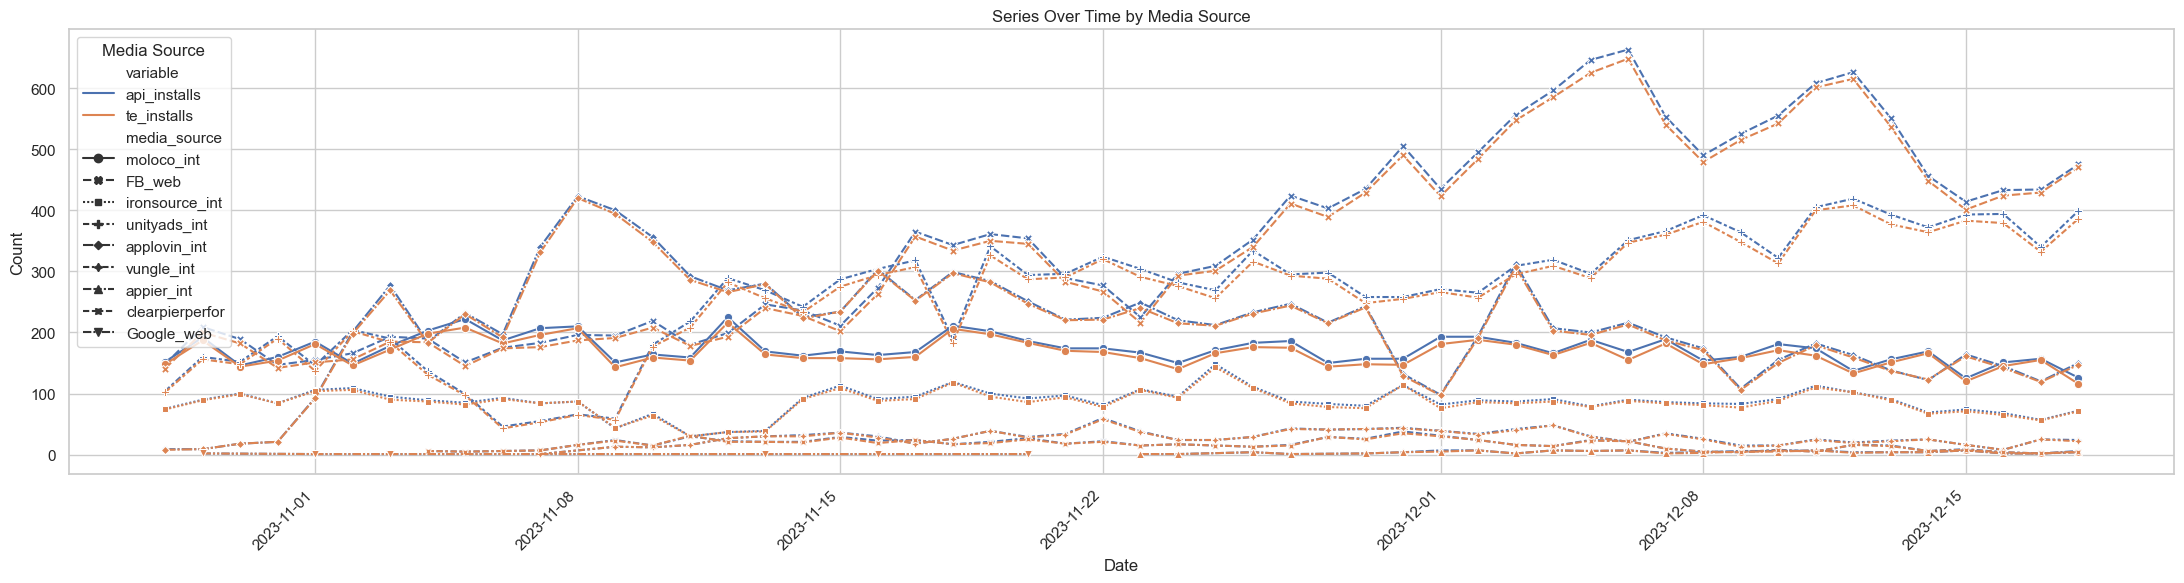

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date', 'media_source'], value_vars=['api_installs', 'te_installs'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

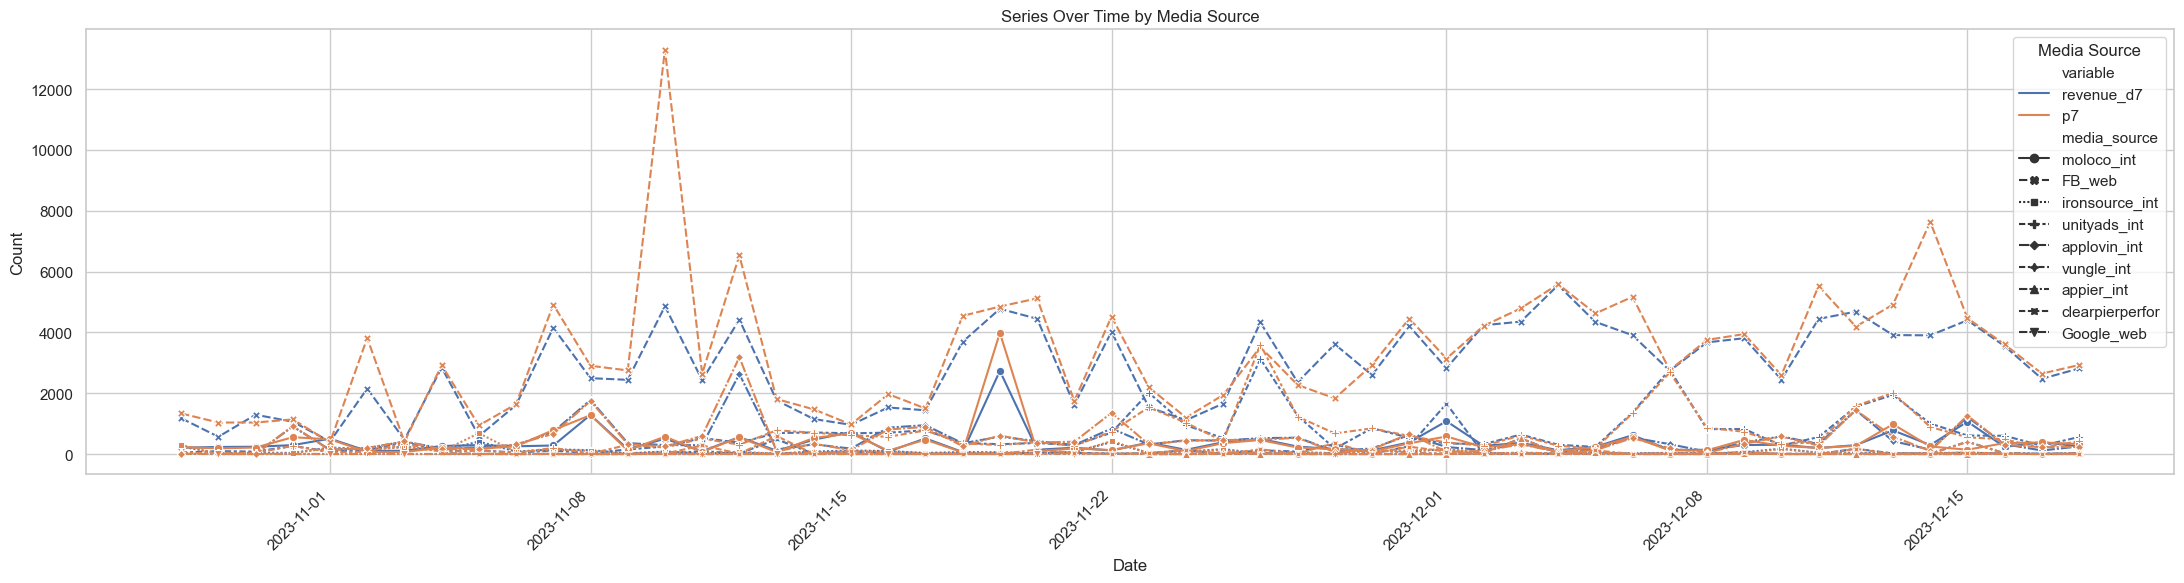

In [20]:
# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date', 'media_source'], value_vars=['revenue_d7', 'p7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

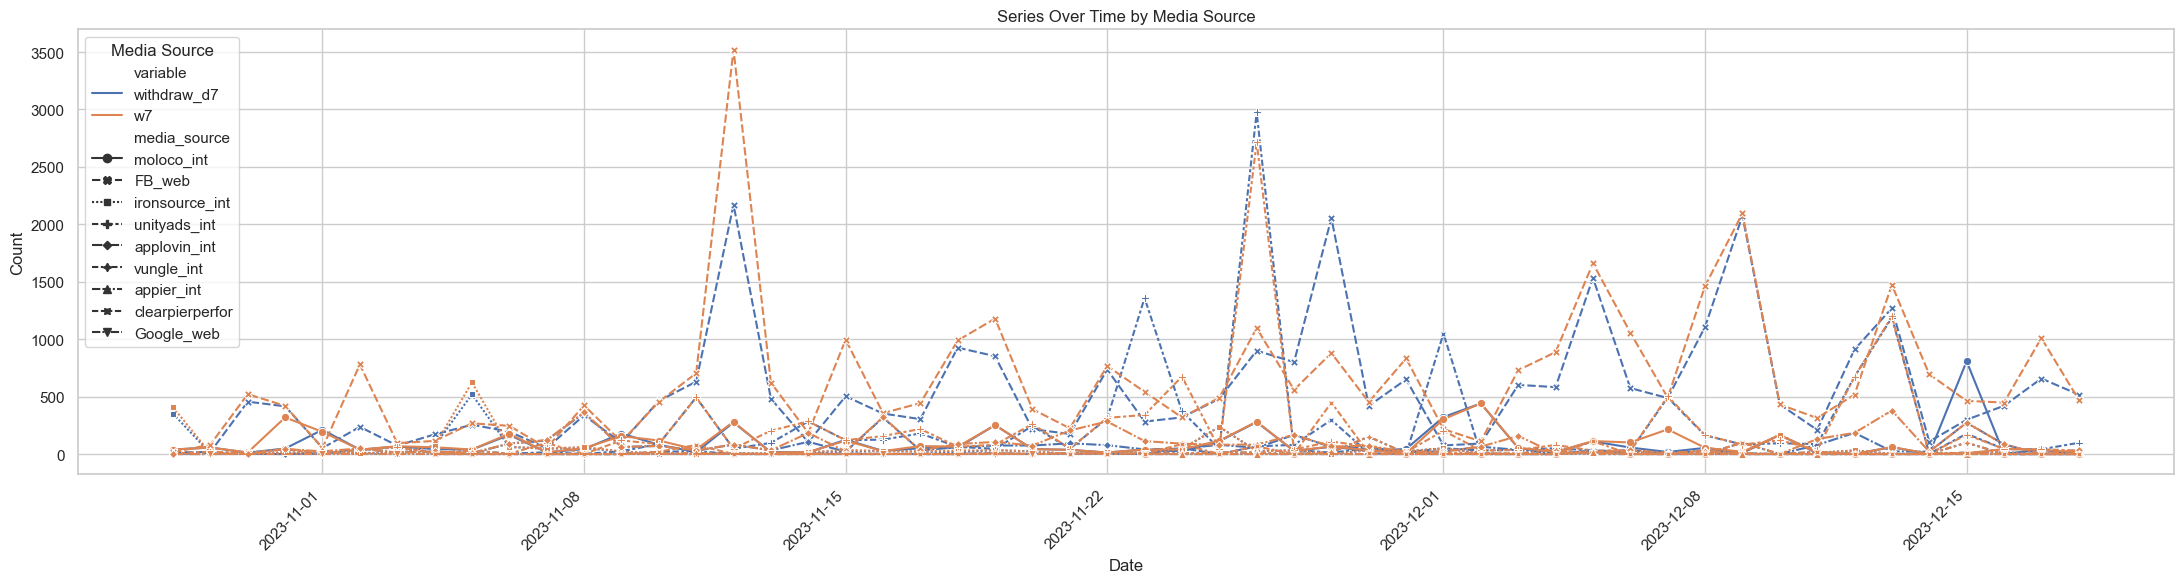

In [21]:
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date', 'media_source'], value_vars=['withdraw_d7', 'w7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

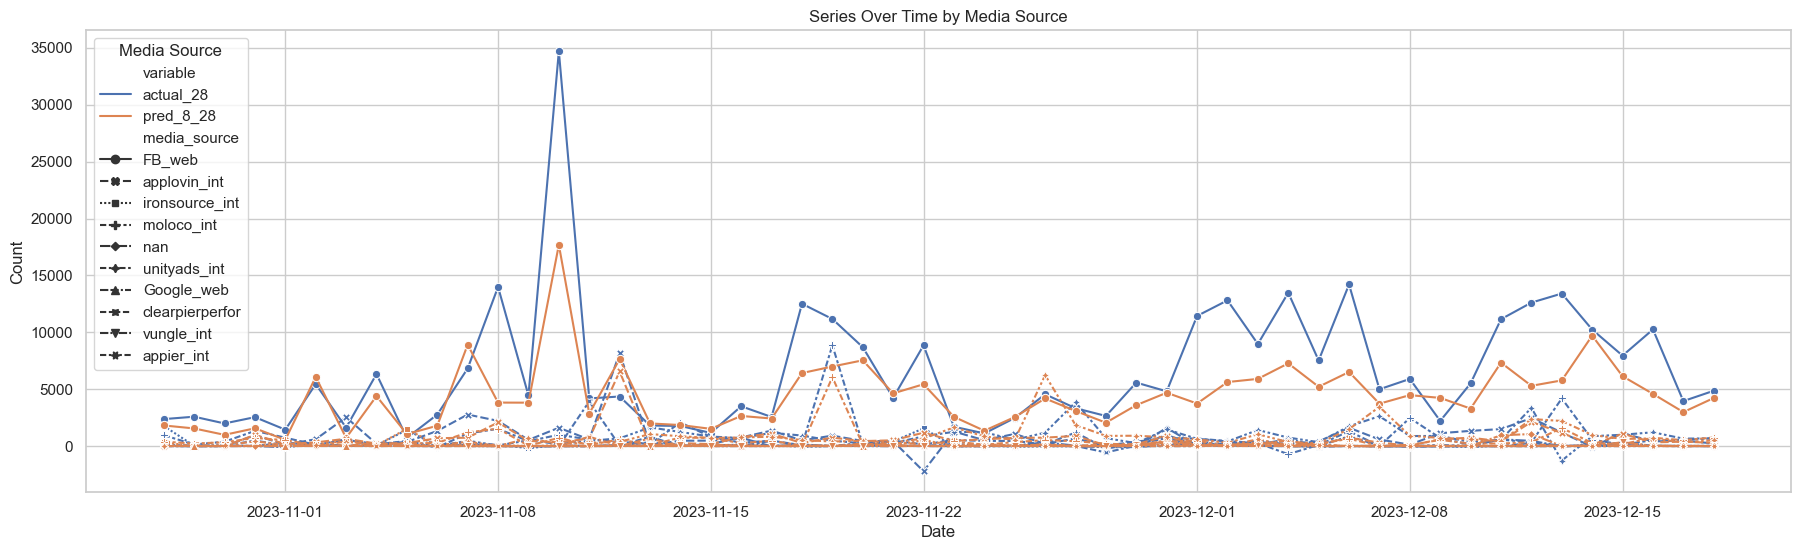

In [22]:
# Convert the 'date' column to datetime if it's not already
graph = df.groupby(['date', 'media_source']).agg({'actual_14': 'sum', 'pred_8_14': 'sum', 'actual_28': 'sum', 'pred_8_28': 'sum'}).reset_index()
# Convert the 'date' column to datetime if it's not already
graph['date'] = pd.to_datetime(graph['date'], format='%Y%m%d')
graph = graph[graph['media_source'] != 'Facebook Ads']

# Set the seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(graph, id_vars=['date', 'media_source'], value_vars=['actual_28', 'pred_8_28'])

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
plt.legend(title='Media Source')

# Show the plot
plt.show()

## 3. Incorporate the responses from the BI tool 

In [23]:
file_path1 = (os.getcwd()).replace('\\', '/') + r'/poker_party_ios\media_source_roi_20240115162517.xlsx'.replace('\\', '/')
file_path2 = (os.getcwd()).replace('\\', '/') + r'/poker_party_ios\media_source_roi_20240115162326.xlsx'.replace('\\', '/')
file_path3 = (os.getcwd()).replace('\\', '/') + r'/poker_party_ios\media_source_roi_20240115162340.xlsx'.replace('\\', '/')
file_path4 = (os.getcwd()).replace('\\', '/') + r'/poker_party_ios\media_source_roi_20240115162351.xlsx'.replace('\\', '/')

df1 = pd.read_excel(file_path1)
df2 = pd.read_excel(file_path2)
df3 = pd.read_excel(file_path3)
df4 = pd.read_excel(file_path4)

bi_tool_actuals = pd.concat([df1, df2, df3, df4], ignore_index=True)
bi_tool_actuals = bi_tool_actuals[bi_tool_actuals['date'] != '--']
bi_tool_actuals[['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']]
# bi_tool_actuals[bi_tool_actuals['channel'] == 'unityads_int'][['date', '7-day recovery (rate)', '14-day recycling (rate)

,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
0,128.14 (5.73%),90.53 (4.05%),90.53 (4.05%)
1,375.99 (18.13%),504.99 (24.35%),504.99 (24.35%)
2,77.63 (3.87%),162.34 (8.09%),162.34 (8.09%)
3,296.65 (9.04%),346.84 (10.57%),346.84 (10.57%)
4,147.70 (4.39%),137.22 (4.08%),137.22 (4.08%)
...,...,...,...
142,116.72 (4.76%),143.37 (5.84%),163.39 (6.66%)
143,564.22 (23.29%),560.61 (23.14%),"1,186.88 (48.99%)"
144,126.51 (5.21%),164.20 (6.76%),216.83 (8.92%)
145,109.46 (4.4%),-254.39 (-10.22%),-653.38 (-26.26%)


In [25]:
bi_tool_actuals[bi_tool_actuals['channel'] == 'unityads_int'][['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
109,2023-12-03 00:00:00,606.12 (14.09%),858.71 (19.96%),"1,501.97 (34.92%)"
108,2023-12-04 00:00:00,256.01 (6.21%),419.44 (10.18%),889.30 (21.58%)
107,2023-12-05 00:00:00,203.05 (4.16%),273.60 (5.6%),460.33 (9.43%)
106,2023-12-06 00:00:00,"1,336.81 (28.73%)","1,600.86 (34.4%)","1,848.90 (39.73%)"
105,2023-12-07 00:00:00,"2,285.13 (41.44%)","2,407.55 (43.66%)","2,788.31 (50.57%)"
104,2023-12-08 00:00:00,656.57 (13.12%),969.98 (19.38%),"1,006.61 (20.11%)"
103,2023-12-09 00:00:00,741.45 (15.59%),806.21 (16.95%),859.02 (18.06%)
102,2023-12-10 00:00:00,185.57 (3.71%),379.37 (7.58%),387.52 (7.75%)
101,2023-12-11 00:00:00,472.53 (7.76%),551.15 (9.05%),696.73 (11.44%)
100,2023-12-12 00:00:00,884.67 (14.48%),"2,229.41 (36.48%)","3,549.41 (58.08%)"


In [26]:
# Convert percentage strings to floats
def convert_percentage_string_to_float(percentage_string):
    try:
        return float(percentage_string.split(' ')[1][1:-2]) / 100
    except (ValueError, IndexError):
        return float(percentage_string.split('（')[1][0:-2]) / 100

for col in ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

bi_tool_actuals[bi_tool_actuals['channel'] == 'unityads_int'][['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
109,2023-12-03 00:00:00,0.1409,0.1996,0.3492
108,2023-12-04 00:00:00,0.0621,0.1018,0.2158
107,2023-12-05 00:00:00,0.0416,0.0560,0.0943
106,2023-12-06 00:00:00,0.2873,0.3440,0.3973
105,2023-12-07 00:00:00,0.4144,0.4366,0.5057
104,2023-12-08 00:00:00,0.1312,0.1938,0.2011
103,2023-12-09 00:00:00,0.1559,0.1695,0.1806
102,2023-12-10 00:00:00,0.0371,0.0758,0.0775
101,2023-12-11 00:00:00,0.0776,0.0905,0.1144
100,2023-12-12 00:00:00,0.1448,0.3648,0.5808


In [27]:
bi_tool_actuals[bi_tool_actuals['channel'] == 'unityads_int'][['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(5)


,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
109,2023-12-03 00:00:00,0.1409,0.1996,0.3492
108,2023-12-04 00:00:00,0.0621,0.1018,0.2158
107,2023-12-05 00:00:00,0.0416,0.0560,0.0943
106,2023-12-06 00:00:00,0.2873,0.3440,0.3973
105,2023-12-07 00:00:00,0.4144,0.4366,0.5057


In [28]:
# MERGE BI TOOL TO MY DATA (AGG DF INCLUDES BI DATA)

bi_tool_wanted_cols = ['date', 'channel', 'Recovery on the 28th (rate)']

agg_df['channel'] = agg_df['media_source']
bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
agg_df = pd.merge(bi_tool_actuals, agg_df, on=['channel', 'date'], how = 'inner')
agg_df


,date,channel,ECPI (installation),CPI(registration),Install,AF new,Register new,spend,PaidCPI,Payer (rate),...,pred_28_133,pred_35_133,te_installs,payment_increase,rpi_increase,installs_difference,is_facebook,is_moloco,is_unity,withdrawn_ratio
0,20231218,applovin_int,22.12,23.16,157,157,150,3473.53,165.41,21 (14%),...,0.202137,0.172839,147,0.073433,0.676533,0.020408,0,0,0,0.131263
1,20231217,applovin_int,21.70,23.14,129,129,121,2799.63,311.07,9(7.44%),...,0.862482,0.857192,119,-0.480565,-0.021750,0.008403,0,0,0,0.000000
2,20231216,applovin_int,21.18,22.06,151,151,145,3198.25,228.45,14 (9.66%),...,0.399812,0.404023,142,0.070510,1.230552,0.021127,0,0,0,0.259562
3,20231215,applovin_int,19.49,19.73,166,166,164,3235.32,248.87,13 (7.93%),...,0.559610,0.841251,161,-0.040716,6.407561,0.018634,0,0,0,0.224565
4,20231214,applovin_int,20.35,21.35,128,128,122,2605.20,289.47,9(7.38%),...,0.377860,0.354342,123,0.443464,0.192541,-0.008130,0,0,0,0.142896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,20231207,moloco_int,12.65,12.78,194,194,192,2453.49,223.04,11(5.73%),...,0.442622,0.532565,182,0.133645,-0.287989,0.038462,0,1,0,0.132645
60,20231206,moloco_int,14.17,14.34,171,171,169,2422.72,134.60,18 (10.65%),...,2.032770,2.027339,155,0.100211,2.695119,0.083871,0,1,0,0.091111
61,20231205,moloco_int,12.79,12.93,189,190,188,2430.02,121.50,20 (10.64%),...,2.332372,3.057054,183,0.079962,0.260904,0.027322,0,1,0,0.466315
62,20231204,moloco_int,14.81,14.81,168,168,168,2488.13,207.34,12 (7.14%),...,0.769493,0.736273,163,0.238395,-0.244157,0.018405,0,1,0,0.127600


### Check the Joint results

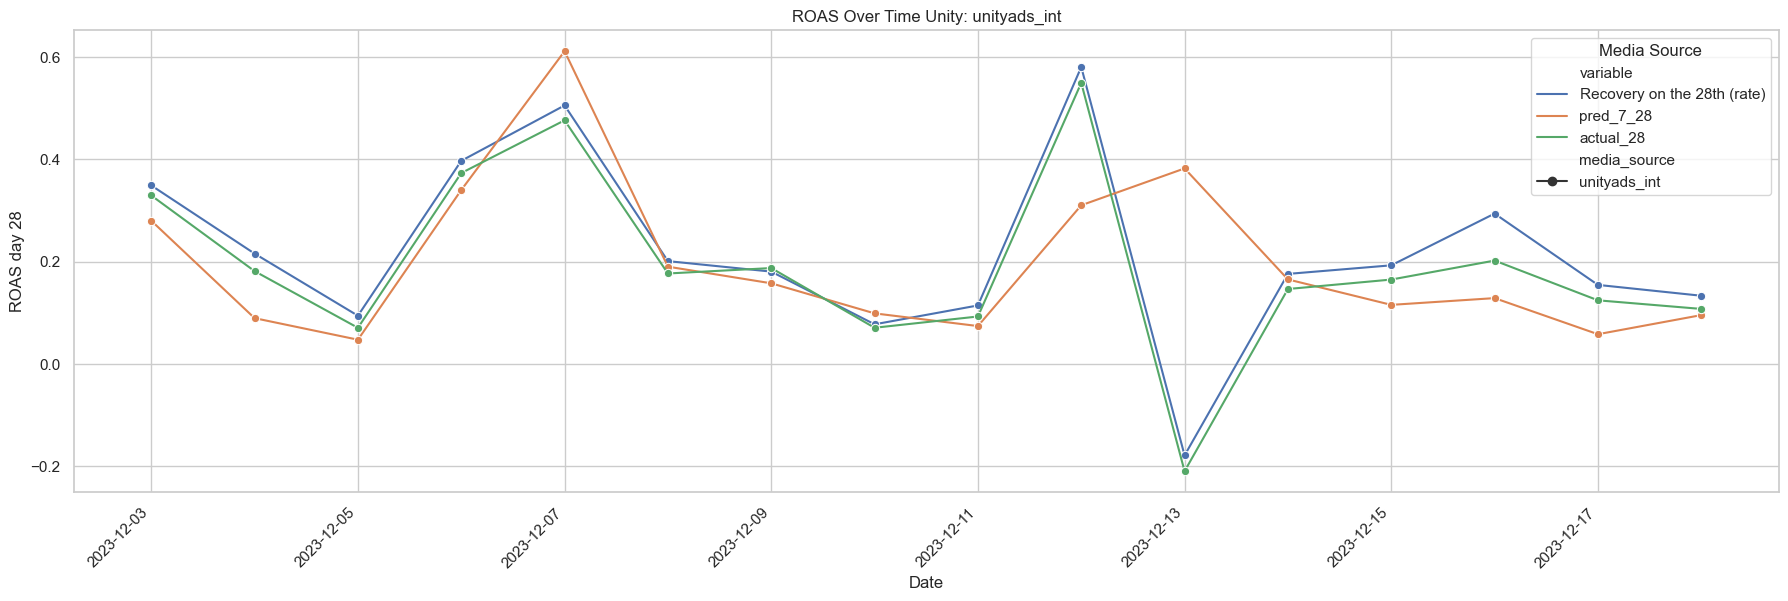

In [29]:

sourcesito = 'unityads_int'

filtered_df = agg_df[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

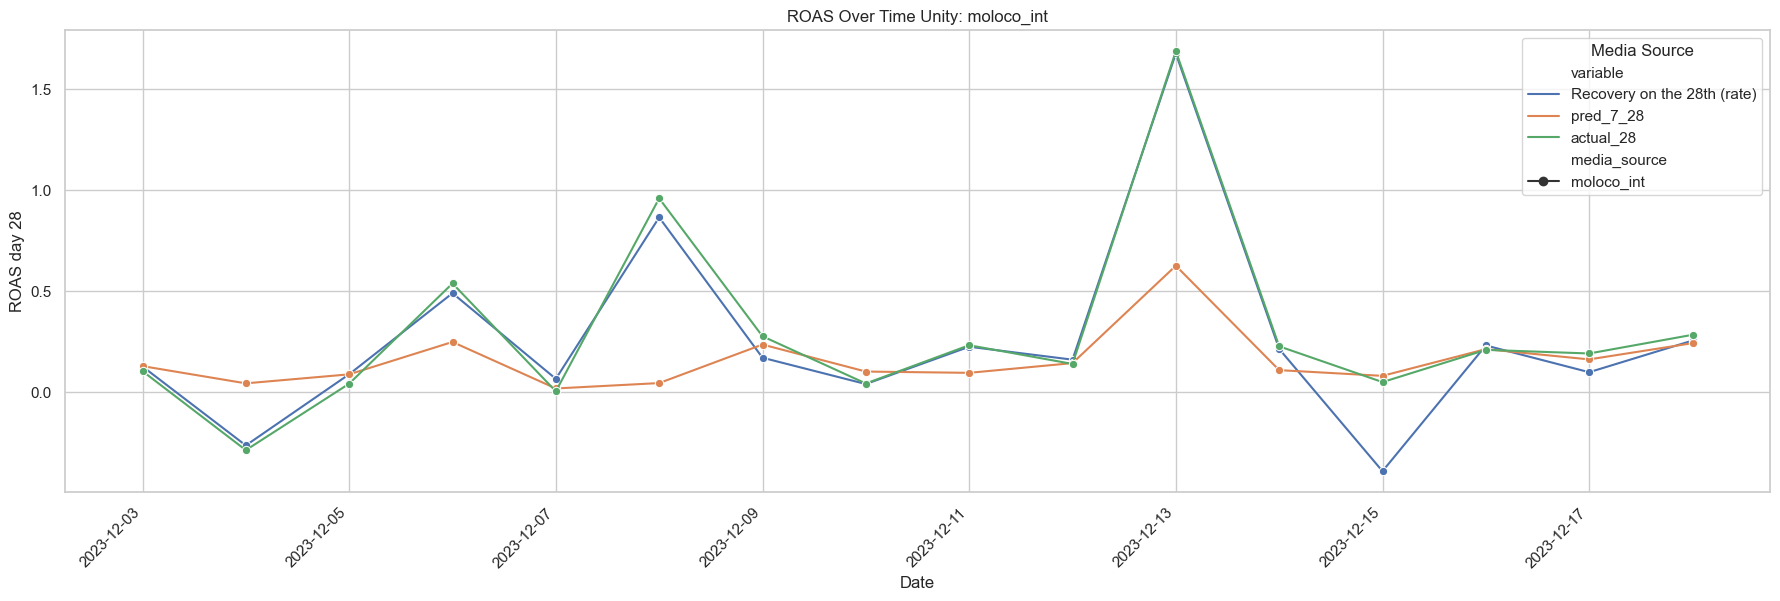

In [30]:
sourcesito = 'moloco_int'

filtered_df = agg_df[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

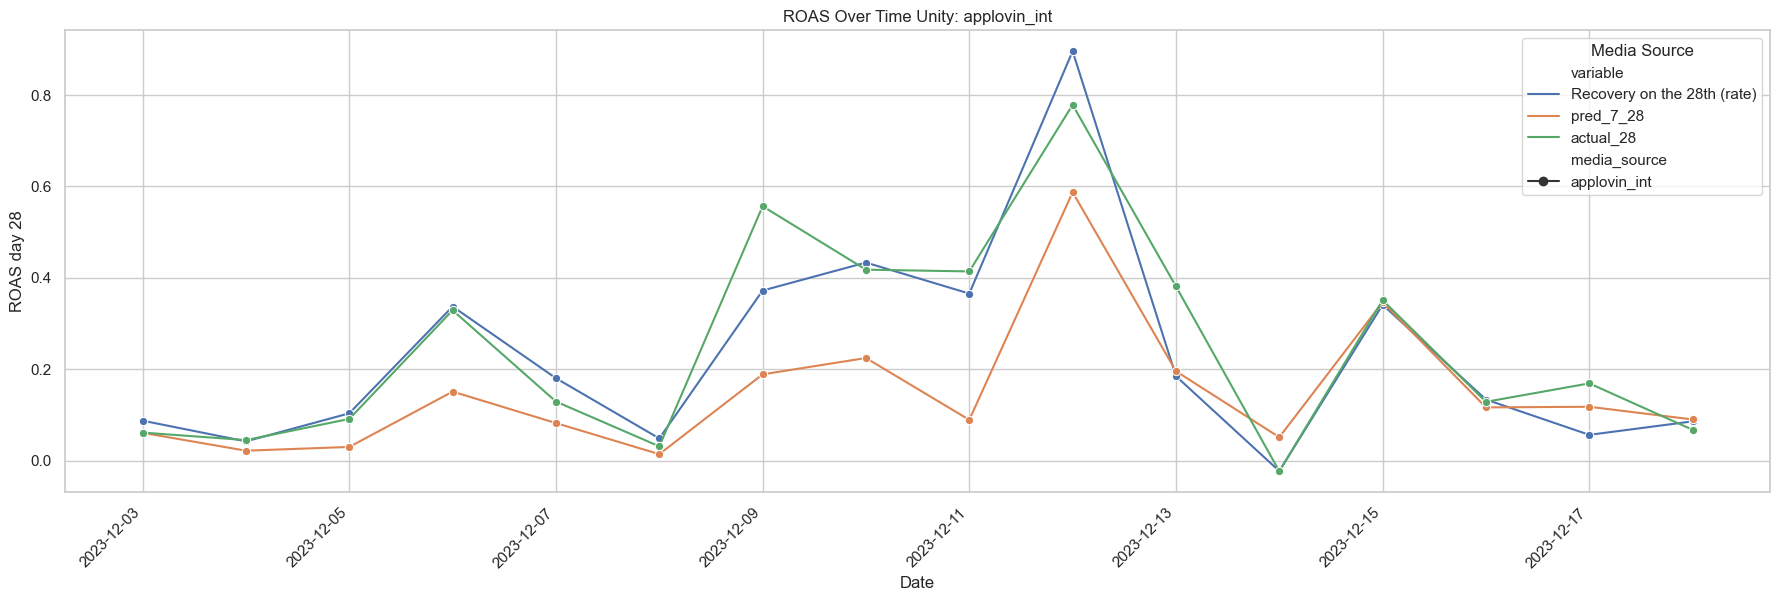

In [31]:
sourcesito = 'applovin_int'

filtered_df = agg_df[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

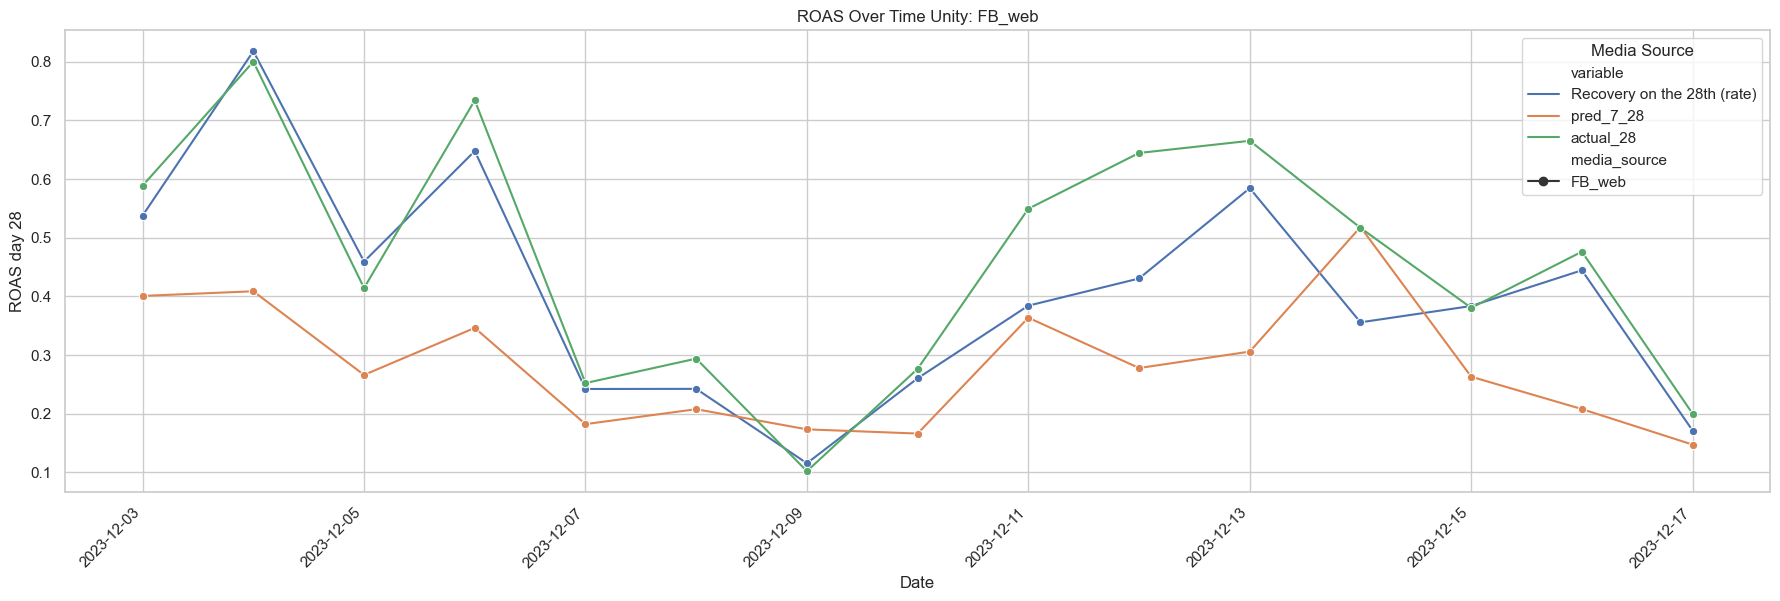

In [29]:
sourcesito = 'FB_web'

filtered_df = agg_df[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

## Find the best configuration to train correction rule

In [44]:
w_col_names = [col for col in agg_df.columns if re.match(r'^w\d*$', col) is not None]
p_col_names = [col for col in agg_df.columns if re.match(r'^p\d*$', col) is not None]
agg_df_train = agg_df[agg_df['api_installs'] > 50][['media_source'] + ['date'] + ['te_installs'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] 
                        + ['rpi_increase'] + ['installs_difference'] + ['is_facebook'] + ['is_moloco'] + ['is_unity'] + ['withdrawn_ratio'] + ['Recovery on the 28th (rate)']
                        + [col for col in agg_df.columns if col.startswith("pred_") ] + w_col_names + p_col_names]

agg_df_train['d7_28_increase_api'] = agg_df_train['Recovery on the 28th (rate)'] - agg_df_train['revenue_d7']/agg_df_train['cost']
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])


In [45]:
# GET THE COLUMN GROUPS
validation_sets = 3
agg_df_train['validation_set_id'] = pd.qcut(agg_df_train['date'].values, validation_sets)

In [46]:
agg_df_train.groupby('validation_set_id').size()

validation_set_id
(20231202.999, 20231208.0]    24
(20231208.0, 20231213.0]      20
(20231213.0, 20231218.0]      20
dtype: int64

In [47]:
agg_df_train.groupby('media_source').size()

media_source
FB_web          16
applovin_int    16
moloco_int      16
unityads_int    16
dtype: int64

In [48]:
# Check for nulls, infinities and select the model_cols
model_cols = agg_df_train[agg_df_train.columns[5:]].columns
model_cols
null_rows = agg_df_train[agg_df_train['payment_increase'].isnull()]
print(null_rows)
infinity_rows = agg_df_train[np.isinf(agg_df_train['payment_increase'])]
infinity_rows

Empty DataFrame
Columns: [media_source, date, te_installs, cost, revenue_d7, withdraw_d7, payment_increase, rpi_increase, installs_difference, is_facebook, is_moloco, is_unity, withdrawn_ratio, Recovery on the 28th (rate), pred_7_14, pred_8_14, pred_9_14, pred_10_14, pred_11_14, pred_12_14, pred_13_14, pred_7_28, pred_8_28, pred_9_28, pred_10_28, pred_11_28, pred_12_28, pred_13_28, pred_14_28, pred_15_28, pred_16_28, pred_17_28, pred_18_28, pred_19_28, pred_20_28, pred_21_28, pred_22_28, pred_23_28, pred_24_28, pred_25_28, pred_26_28, pred_27_28, pred_7_56, pred_8_56, pred_9_56, pred_10_56, pred_11_56, pred_12_56, pred_13_56, pred_14_56, pred_15_56, pred_16_56, pred_17_56, pred_18_56, pred_19_56, pred_20_56, pred_21_56, pred_22_56, pred_23_56, pred_24_56, pred_25_56, pred_26_56, pred_27_56, pred_28_56, pred_35_56, pred_7_63, pred_8_63, pred_9_63, pred_10_63, pred_11_63, pred_12_63, pred_13_63, pred_14_63, pred_15_63, pred_16_63, pred_17_63, pred_18_63, pred_19_63, pred_20_63, pred_21_6

,media_source,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,is_facebook,...,p70,p77,p8,p84,p9,p91,p98,d7_28_increase_api,d7_28_increase_pred,validation_set_id


### Modelling

In [49]:
def create_huber(alpha, epsi, cols, weights_train): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )


    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept = True, epsilon = epsi, alpha = alpha, warm_start = False, max_iter = 1000))
    ])

    pipe.named_steps['regressor'].sample_weight = weights_train

    return pipe

def all_feature_enginerring(data, pred_col):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Inclusion of interpolation 
    column_list = ['withdrawn_ratio', pred_col, 'installs_difference', 'is_facebook']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    return data


In [50]:
model_cols = ['return_withdraw_d7', 'return_p_d7', 'payment_increase', 'rpi_increase', 'installs_difference', 'is_facebook', 'is_moloco', 'is_unity', 'withdrawn_ratio', 'd7_28_increase_api', 'd7_28_increase_pred', 'te_installs']

In [51]:
agg_df_train['return_withdraw_d7'] = agg_df_train['withdraw_d7'] / agg_df_train['cost'] 
agg_df_train['return_p_d7'] = agg_df_train['p7'] / agg_df_train['cost'] 
agg_df_train[model_cols].sample(10)

,return_withdraw_d7,return_p_d7,payment_increase,rpi_increase,installs_difference,is_facebook,is_moloco,is_unity,withdrawn_ratio,d7_28_increase_api,d7_28_increase_pred,te_installs
30,0.034585,0.331537,-0.005937,8.317987,0.018803,1,0,0,0.104941,0.488332,0.111771,585
43,0.089308,0.486970,0.034397,6.589044,0.016667,0,0,1,0.177298,0.001980,0.214108,360
34,0.007369,0.080453,0.245104,0.527132,0.039578,0,0,1,0.073559,0.193928,0.055662,379
54,0.000381,0.114564,0.084652,1.141022,0.030075,0,1,0,0.003068,0.037038,0.030104,133
10,0.008048,0.010911,0.787158,-0.552759,0.017544,0,0,0,0.412747,0.028900,0.011160,171
4,0.007980,0.038689,0.443464,0.192541,-0.008130,0,0,0,0.142896,-0.078846,0.020337,123
45,0.006184,0.036668,0.302894,-0.212027,0.024221,0,0,1,0.129437,0.046526,0.016916,289
37,0.195502,0.330995,-0.033288,3.946819,0.042440,0,0,1,0.610987,-0.498877,0.246962,377
57,0.004064,0.182483,-0.364103,0.854250,0.012658,0,1,0,0.035021,0.054859,0.057674,158
14,0.001064,0.014505,0.295384,-0.597198,0.019704,0,0,0,0.056608,0.023211,0.008180,203


In [82]:
model_results = []
all_model_results = []
alphas = [0, 0.005, 0.1, 0.2, 0.3, 0.5, 1] 
alphas = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2] 
epsils = [1, 1.05, 1.1, 1.3, 1.5, 1.7, 2, 2.5, 3] 
model_cols = [col for col in model_cols if col != 'cost']

# for train_index, test_index in splits:
for date_group in tqdm(agg_df_train['validation_set_id'].unique()):
    
    print(date_group)

    train_data =  agg_df_train[agg_df_train['validation_set_id'] != date_group][model_cols]
    test_data =  agg_df_train[agg_df_train['validation_set_id'] == date_group][model_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_28_increase_api']), train_data[f'd7_28_increase_api']
    X_test, y_test = test_data.drop(columns = [f'd7_28_increase_api']), test_data[f'd7_28_increase_api']

    old_cols = X_train[[col for col in X_train.columns if col != 'te_installs']].copy().columns
    X_train = all_feature_enginerring(X_train, 'd7_28_increase_pred')
    X_test = all_feature_enginerring(X_test, 'd7_28_increase_pred')

    weights_train = np.log1p(X_train['te_installs'])

    for alpha in alphas: 
        for epsi in epsils: 
            for cols in [old_cols, X_train.columns]:
                
                # Full trainning and testing 
                model = create_huber(alpha, epsi, old_cols, weights_train)
                model.fit(X_train[[col for col in cols if col != 'te_installs']], y_train)
                predictions = model.predict(X_test[[col for col in X_train.columns if col != 'te_installs']])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len([col for col in cols if col != 'te_installs']))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    all_model_results.extend(model_results)

  0%|          | 0/3 [00:00<?, ?it/s]

(20231213.0, 20231218.0]


 33%|███▎      | 1/3 [00:04<00:09,  4.61s/it]

(20231208.0, 20231213.0]


 67%|██████▋   | 2/3 [00:07<00:03,  3.86s/it]

(20231202.999, 20231208.0]


100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


In [100]:
old_cols

Index(['return_withdraw_d7', 'return_p_d7', 'payment_increase', 'rpi_increase',
       'installs_difference', 'is_facebook', 'is_moloco', 'is_unity',
       'withdrawn_ratio', 'd7_28_increase_pred'],
      dtype='object')

In [83]:
all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])
all_model_results.sort_values(by = 'mae').head(12)

,Iteration,Test at,Model,mae,r2,rel_mae
39,0.01 - 1.05 - 16,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095529,0.671643,0.188581
471,0.01 - 1.05 - 16,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095529,0.671643,0.188581
183,0.01 - 1.05 - 16,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095529,0.671643,0.188581
562,0.2 - 1.1 - 10,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095898,0.653753,0.185450
274,0.2 - 1.1 - 10,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095898,0.653753,0.185450
130,0.2 - 1.1 - 10,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095898,0.653753,0.185450
544,0.15 - 1.1 - 10,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095962,0.653305,0.184900
112,0.15 - 1.1 - 10,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095962,0.653305,0.184900
256,0.15 - 1.1 - 10,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.095962,0.653305,0.184900
94,0.1 - 1.1 - 10,"(20231213.0, 20231218.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.096044,0.652783,0.184206


In [84]:
all_model_results.shape[0]

864

In [85]:
all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'mae', ascending = True).head(50)


,mae,r2,rel_mae
Iteration,,,
0 - 1 - 10,0.131458,0.372780,0.143162
0.2 - 1.1 - 10,0.131467,0.366489,0.145467
0.01 - 1.05 - 16,0.131503,0.372794,0.146173
0 - 1.1 - 10,0.131780,0.363738,0.143283
0.01 - 1.1 - 10,0.131792,0.363487,0.143214
0.2 - 1.05 - 10,0.131852,0.363564,0.142693
0.1 - 1.1 - 10,0.131887,0.361962,0.142570
0.005 - 1.1 - 10,0.131896,0.361950,0.142514
0.05 - 1.1 - 10,0.131910,0.361734,0.142439


In [58]:
def all_feature_enginerring(data, pred_col):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Inclusion of interpolation 
    column_list = ['withdrawn_ratio', pred_col, 'installs_difference', 'is_facebook']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    return data

In [86]:
model_value = all_model_results.loc[all_model_results['Iteration'] == '0 - 1 - 10', 'Model'].iloc[0]
reset_df_plus = all_feature_enginerring(agg_df_train, 'd7_28_increase_pred')
cols_to_append = [
    'roas_d7_times_installs_difference',
    'withdrawn_ratio_times_installs_difference',
    'withdrawn_ratio_times_pred_7_28',
    'roas_d7_times_pred_7_28',
    'roas_d7_times_withdrawn_ratio',
    'pred_7_28_times_installs_difference'
]
cols_to_append = [
    'withdrawn_ratio_times_d7_28_increase_pred',
    'withdrawn_ratio_times_installs_difference',
    'd7_28_increase_pred_times_installs_difference', 
    'withdrawn_ratio_times_is_facebook', 'installs_difference_times_is_facebook', 'd7_28_increase_pred_times_is_facebook'
]

subnormal = [col for col in old_cols if col != 'Installs']
subnormal.extend(cols_to_append)
subnormal

predictions = model_value.predict(reset_df_plus[subnormal])

In [87]:
import pandas as pd
import plotly.express as px

# Assuming reset_df is your DataFrame
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': (agg_df_train['revenue_d7']/agg_df_train['cost']), 'installs': agg_df_train['te_installs'], 'channel': agg_df_train['media_source']})

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs ROAS day 7', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',
                 color='channel',  # Set color based on 'channel'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [88]:
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': predictions, 'installs': agg_df_train['te_installs'], 'channel': agg_df_train['media_source']})

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',
                 color='channel',  # Set color based on 'channel'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)


In [89]:
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': predictions, 'installs': agg_df_train['te_installs'], 'channel': agg_df_train['media_source']})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',  # Set size proportional to 'installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [90]:
pdf = pd.DataFrame({'y_test': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + agg_df_train['d7_28_increase_api'].values), 'predictions': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + predictions), 'installs': agg_df_train['te_installs']})
# 'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': agg_df_train['pred_7_28'], 'installs': agg_df_train['te_installs'], 'channel': agg_df_train['media_source']
# Create a scatter plot with size proportional to 'installs'
fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',  # Set size proportional to 'installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

## Fit to dictionary based on availables

In [91]:
dev_df = agg_df_train.copy(deep = True)

In [92]:
columns_rule = ['revenue_d7','withdraw_d7','installs','payment_increase','rpi_increase','installs_difference','is_facebook','pred_roas','roas_d7','withdrawn_ratio']
columns_rule = ['revenue_d7','withdraw_d7','payment_increase','rpi_increase','installs_difference','is_facebook']


In [93]:
dev_df.columns

Index(['media_source', 'date', 'te_installs', 'cost', 'revenue_d7',
       'withdraw_d7', 'payment_increase', 'rpi_increase',
       'installs_difference', 'is_facebook',
       ...
       'd7_28_increase_pred', 'validation_set_id', 'return_withdraw_d7',
       'return_p_d7', 'withdrawn_ratio_times_d7_28_increase_pred',
       'withdrawn_ratio_times_installs_difference',
       'withdrawn_ratio_times_is_facebook',
       'd7_28_increase_pred_times_installs_difference',
       'd7_28_increase_pred_times_is_facebook',
       'installs_difference_times_is_facebook'],
      dtype='object', length=435)

In [94]:

max_date = df['date'].max()
dev_df['days_since_install'] = (max_date - dev_df['date']) # Needed? Yes


In [ ]:
for y_day in tqdm(['28']):
  for x_day in predictors_days:
    for source in ['FB', 'Others']: 
      if int(y_day) > int(x_day):

        


In [95]:
payback_predictive_system = []

from tqdm import tqdm, tqdm_notebook

for y_day in tqdm(['28']):
  for x_day in predictors_days:
    for source in ['FB', 'Others']: 
      if int(y_day) > int(x_day):

        if source == 'FB': 
          train = dev_df[dev_df['media_source'] == 'FB_web']
        else: 
          train = dev_df[dev_df['media_source'] != 'FB_web']
      
        if y_day == '14':
          train['y'] = train['14-day recycling (rate)'] - (train[f'p{x_day}'] - train[f'w{x_day}'])/train['cost']
        else: 
          train['y'] = train['Recovery on the 28th (rate)'] - (train[f'p{x_day}'] - train[f'w{x_day}'])/train['cost']
        
        y = train[train['days_since_install'] <= (int(y_day) - 1)]['y'] # This is the regressors-based of d7_28_increment
        del train['y']
        del train['Recovery on the 28th (rate)']
  
        # Make the regressors
        selected_columns = columns_rule + [f'pred_{x_day}_{y_day}']
        
        # Define X 
        X = train[train['days_since_install'] <= (int(y_day) - 1)]
        weights_train = np.log1p(X['te_installs'])
  
        # Define observation importance 0.01 - 1.05 - 160 - 1 - 10
        model = create_huber(0, 1, selected_columns, weights_train)
        model.fit(X[[col for col in selected_columns if col != 'te_installs']], y)
  
        # Save the model into dictionary (Response, day, model)
        payback = pd.DataFrame({
                'media_source': [source]
                , 'Available day': [x_day]
                , 'Target day': [y_day]
                , 'Model': [model]
                , 'Columns': [X.columns]
                })
  
        payback_predictive_system.append(payback)

rules_dict = pd.concat(payback_predictive_system, ignore_index = True)
rules_dict

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


,media_source,Available day,Target day,Model,Columns
0,FB,7,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
1,Others,7,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
2,FB,8,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
3,Others,8,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
4,FB,9,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
5,Others,9,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
6,FB,10,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
7,Others,10,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
8,FB,11,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."
9,Others,11,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['media_source', 'date', 'te_installs', ..."


In [96]:
dev_df_check = dev_df.copy(deep = True)

In [97]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]

def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:

        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
            
                for source in ['FB', 'Others']:
                
                
                      columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response) & (model_dict['media_source'] == source)][['Columns']].reset_index(drop = True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
    
                      # Load the model
                      model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response) & (model_dict['media_source'] == source)]['Model'].reset_index(drop = True).values[0]
    
                      # Make the prediction (Make sure is done only for those on which makese sense)
                      prediction = model.predict(data[columns])
                      data[f'pred_{reg}_{response}_{source}_agg'] = prediction + (data[f'p{reg}']- data[f'w{reg}'])/data[f'cost']
                
                data[f'pred_{reg}_{response}_agg'] = data[f'pred_{reg}_{response}_FB_agg'].combine_first(data[f'pred_{reg}_{response}_Others_agg'])


    return data

dev_df_check = add_predictions(dev_df_check, rules_dict, ['28'], predictors_days_input)


In [98]:
dev_df_check.sample(6)

,media_source,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,is_facebook,...,pred_24_28_agg,pred_25_28_FB_agg,pred_25_28_Others_agg,pred_25_28_agg,pred_26_28_FB_agg,pred_26_28_Others_agg,pred_26_28_agg,pred_27_28_FB_agg,pred_27_28_Others_agg,pred_27_28_agg
16,FB_web,20231218,470,20322.09,2814.63,518.00,-0.038494,4.925537,0.010638,1,...,0.238500,0.210088,0.326436,0.210088,0.238128,0.289600,0.238128,0.193857,0.299002,0.193857
4,applovin_int,20231214,123,2605.20,145.49,20.79,0.443464,0.192541,-0.008130,0,...,0.351389,0.133875,-0.061139,0.133875,0.177711,-0.051799,0.177711,0.034820,-0.053223,0.034820
33,unityads_int,20231217,332,5259.72,274.56,41.48,0.355934,-0.192471,0.024096,0,...,0.455273,0.360418,0.136831,0.360418,0.378973,0.136800,0.378973,0.289963,0.141941,0.289963
44,unityads_int,20231206,347,4653.40,1364.07,27.26,0.016120,2.886239,0.011527,0,...,0.582917,0.521416,0.419988,0.521416,0.475382,0.397900,0.475382,0.408144,0.402570,0.408144
46,unityads_int,20231204,309,4121.19,306.94,50.93,0.126864,-0.037806,0.032362,0,...,0.420167,0.345596,0.193648,0.345596,0.376602,0.213768,0.376602,0.308259,0.212491,0.308259
7,applovin_int,20231211,179,3615.20,326.95,79.02,0.183020,0.796429,0.016760,0,...,0.760505,0.674145,0.384562,0.674145,0.600077,0.389764,0.600077,0.546163,0.407504,0.546163


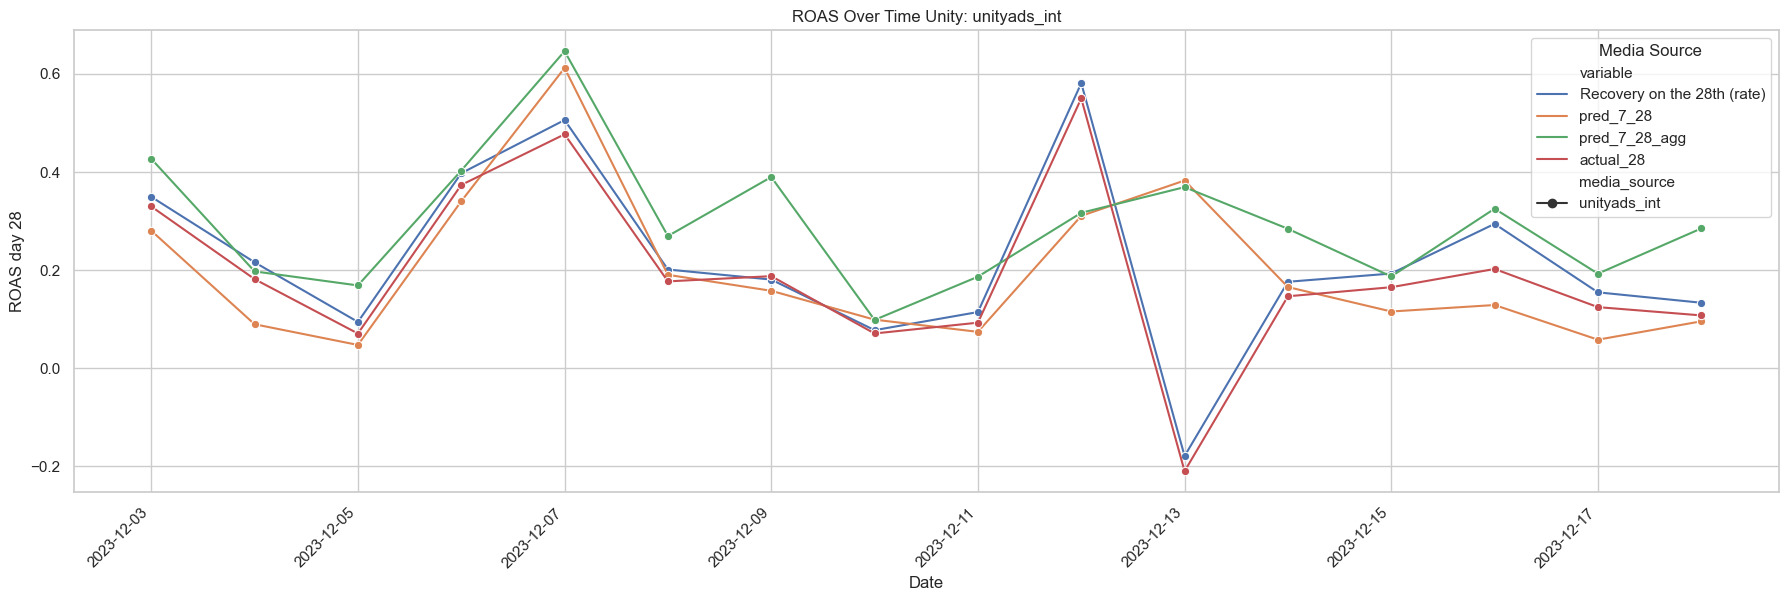

In [99]:
### Check the Joint results

sourcesito = 'unityads_int'

filtered_df = dev_df_check[dev_df_check['media_source'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by = 'date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'pred_7_28_agg', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

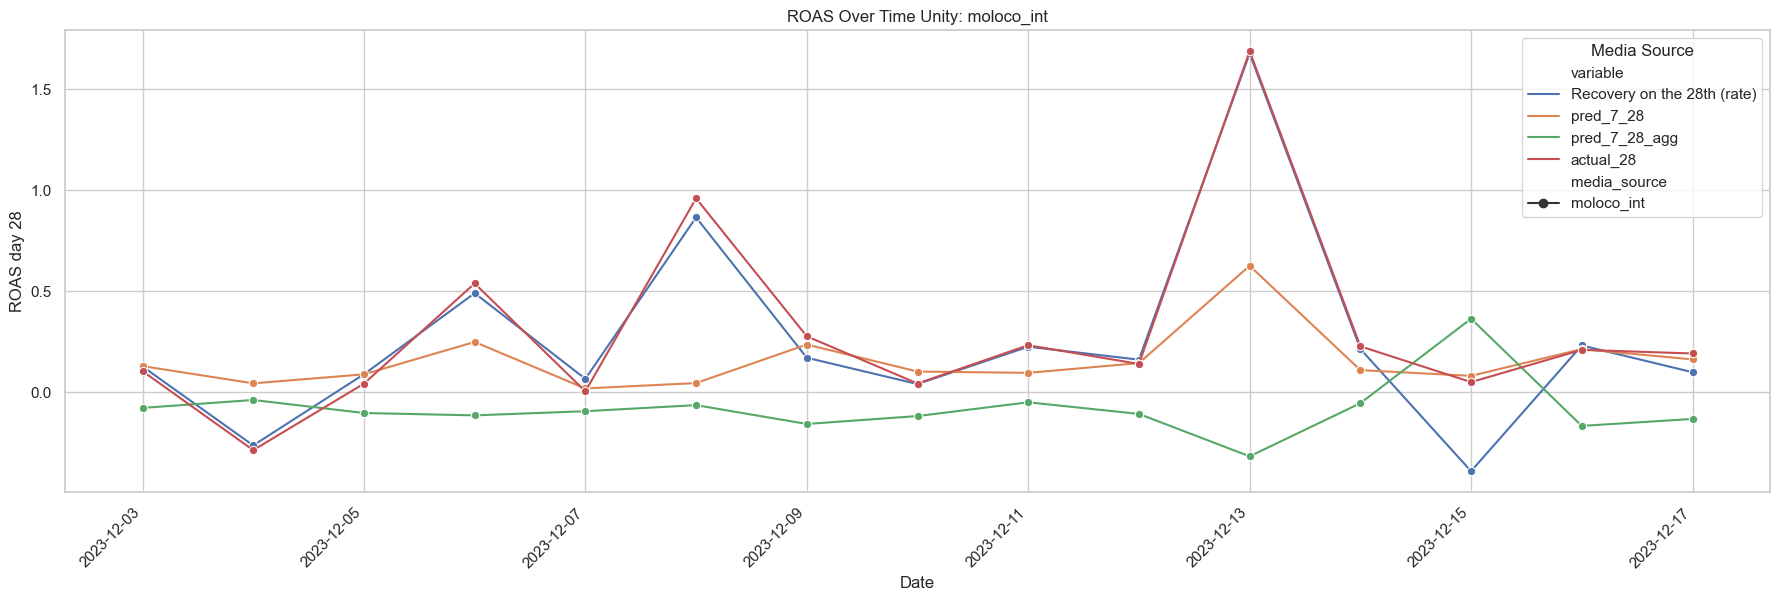

In [194]:

sourcesito = 'moloco_int'

filtered_df = dev_df_check[dev_df_check['media_source'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'pred_7_28_agg', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()
sourcesito = 'applovin_int'


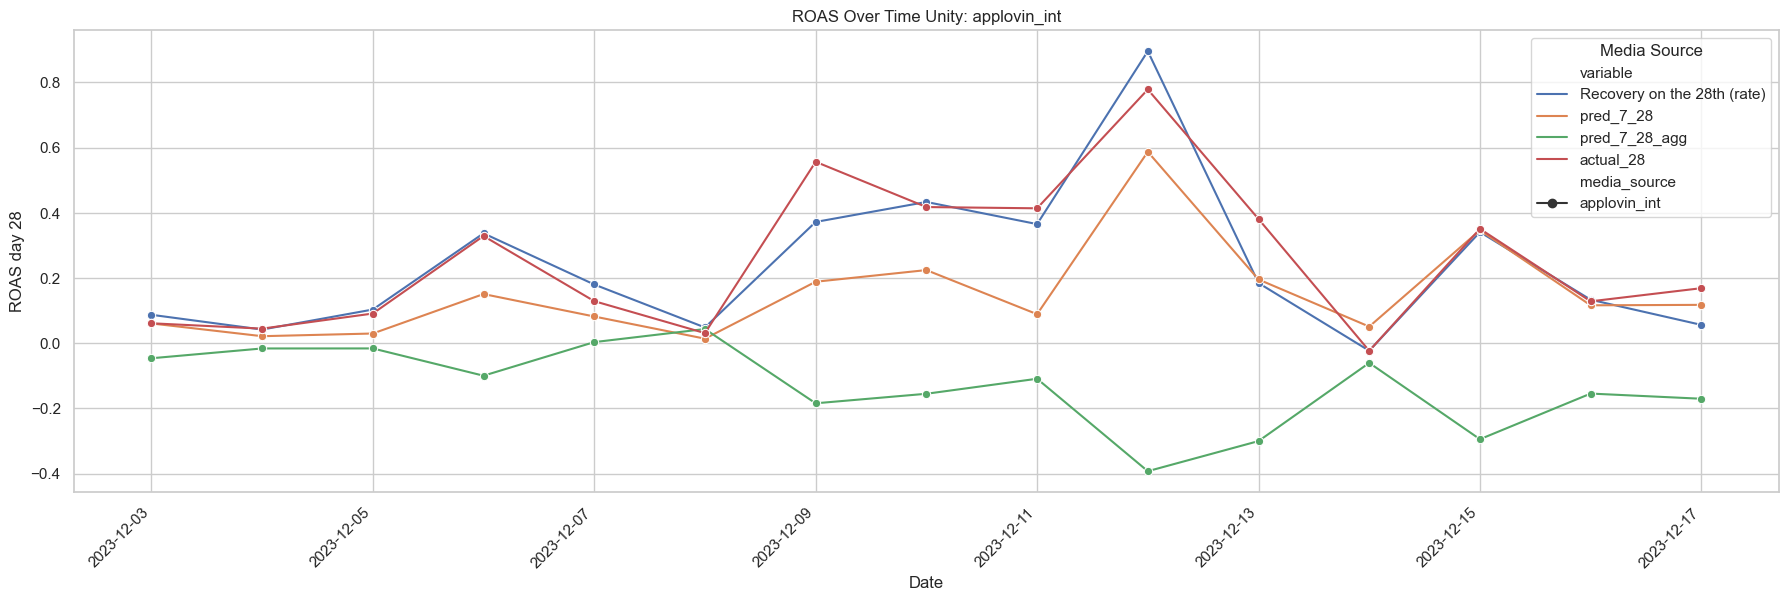

In [195]:

filtered_df = dev_df_check[dev_df_check['media_source'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'pred_7_28_agg', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

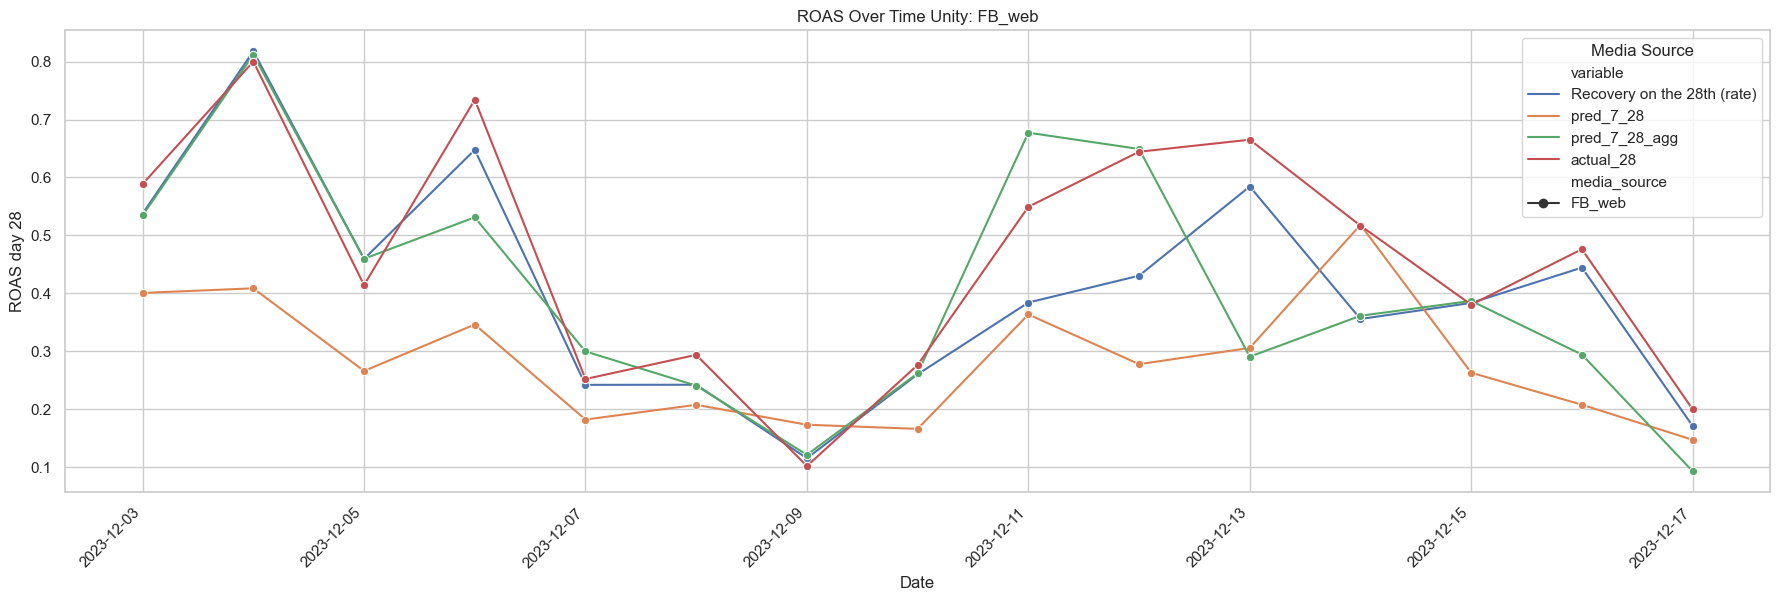

In [196]:

sourcesito = 'FB_web'

filtered_df = dev_df_check[dev_df_check['media_source'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date', 'media_source'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'pred_7_28_agg', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', style='media_source', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ' + sourcesito)

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [80]:
# Remove the last data points and remove the pred_ columns. This is too much
with open('poker_party_ios_ptlv_dictionary_2024.pkl', 'wb') as file:
    pickle.dump(rules_dict, file)

In [107]:
# dev_df['pred_roas'] = dev_df['pred_7_28'] / dev_df['cost']
# dev_df['roas_d7'] = (dev_df['revenue_d7'] - dev_df['withdraw_d7']) / dev_df['cost']
# dev_df['withdrawn_ratio'] = dev_df['withdraw_d7'] / dev_df['revenue_d7']
# dev_df['d7_28_increment'] = dev_df['Recovery on the 28th (rate)'] - dev_df['roas_d7']

In [108]:
# # Functions
# # def gen_dates_and_df(source_df): 
# #     return result_df, unique_dates

# def filter_to_source_include_k(source_df, today): 
#     source_df['date'] = source_df.register_time.dt.normalize()
#     source_df['k'] = (today - source_df['date']).dt.days + 1 
#     return source_df

# today = pd.to_datetime((datetime.now() - timedelta(days = 1)).strftime('%Y-%m-%d'))
# n_values = agg_df.columns[agg_df.columns.str.match(r'pred_\d+_\d+')].str.extract(r'pred_\d+_(\d+)').dropna()[0].unique() # These are the responses, after removing the availables.
# available_k_values = [int(col.split('_')[1]) for col in agg_df.columns if col.startswith('pred_')] # What are the numbers after 'pred_'
# pred_list = ['pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77', 'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112', 'pred_119', 'pred_126', 'pred_133']
# pred_list

['pred_14',
 'pred_28',
 'pred_56',
 'pred_63',
 'pred_70',
 'pred_77',
 'pred_84',
 'pred_91',
 'pred_98',
 'pred_100',
 'pred_105',
 'pred_112',
 'pred_119',
 'pred_126',
 'pred_133']

In [109]:
# new_datasets = {}
# unique_values = agg_df['media_source'].unique()
# for value in unique_values:
#     new_datasets[value] = agg_df[agg_df['media_source'] == value].copy()